In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
from arch.univariate import arch_model
import armagarch as ag
from scipy.stats import shapiro

# Part A: Stylised facts and GARCH modelling

This part is about statistical analysis and modelling of the EURO STOXX 50 (symbol: SX5E) stock market index. The index measures the performance of the 50 largest
and most liquid Eurozone stocks. The file QRM-2023-cw1-data-a.csv contains its daily values at market close from 30 October 2013 to 27 October 2023. Using the index values, compute first the daily log returns (in percentage).

In [2]:
file_path = r'C:\Users\thoma\OneDrive\Bureau\imperial\QRM-2023-cw1-data-a.csv'
df = pd.read_csv(file_path)
df.head()

,Date,Adj Close
0,30/10/2013,3040.689941
1,31/10/2013,3067.949951
2,01/11/2013,3052.139893
3,04/11/2013,3061.179932
4,05/11/2013,3035.919922


## (0) Computing the daily returns

The column "adjclose" contains the time series of asset price $S_t$ that we want to work with. The difference between "close" and "adjclose" is that the latter has been properly adjusted for dividends payout.

Let's create a column of daily log return. The log return is given by $$r_t:=\ln S_t - \ln S_{t-1}=\ln(1+R_t).$$

We store the values in two new pandas columns called "logreturn". We also multiply the two columns by 100 so the values are now in percentage terms.

In [3]:
df['simplereturn'] = df['Adj Close'].pct_change()
df['logreturn'] = np.log(1 + df['simplereturn'])
# Multiply the return values by 100 so they represent percentage values
df['logreturn'] = df['logreturn'] * 100
df.head()

,Date,Adj Close,simplereturn,logreturn
0,30/10/2013,3040.689941,NaN,NaN
1,31/10/2013,3067.949951,0.008965,0.892513
2,01/11/2013,3052.139893,-0.005153,-0.516662
3,04/11/2013,3061.179932,0.002962,0.295749
4,05/11/2013,3035.919922,-0.008252,-0.828596


We can visualise the asset prices and the daily returns.

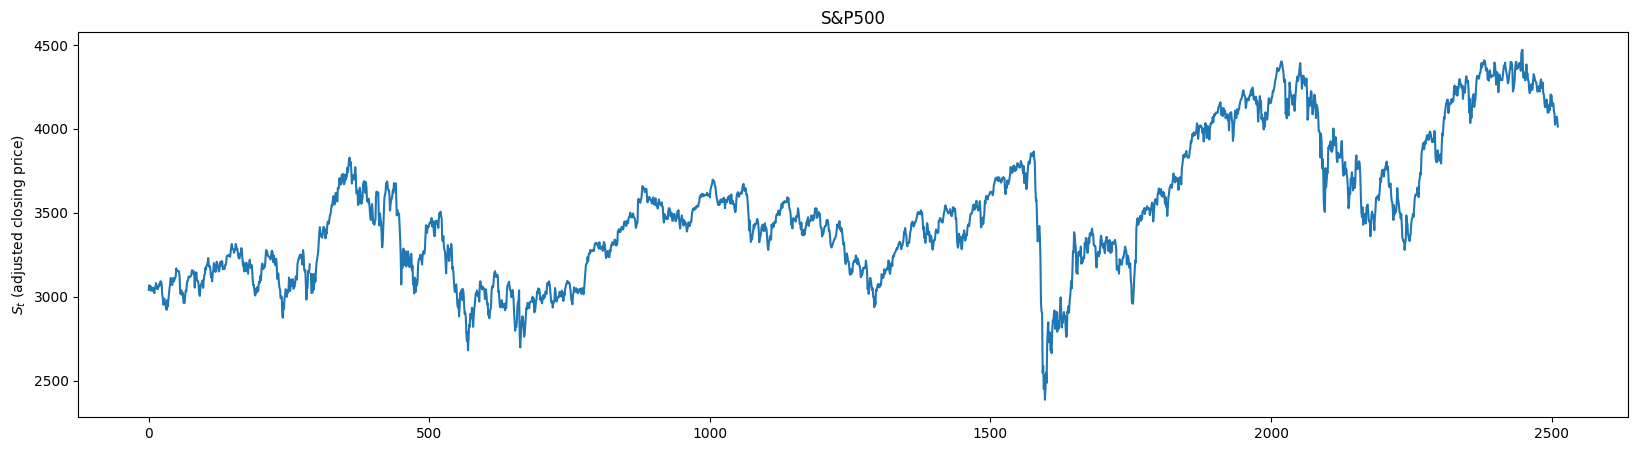

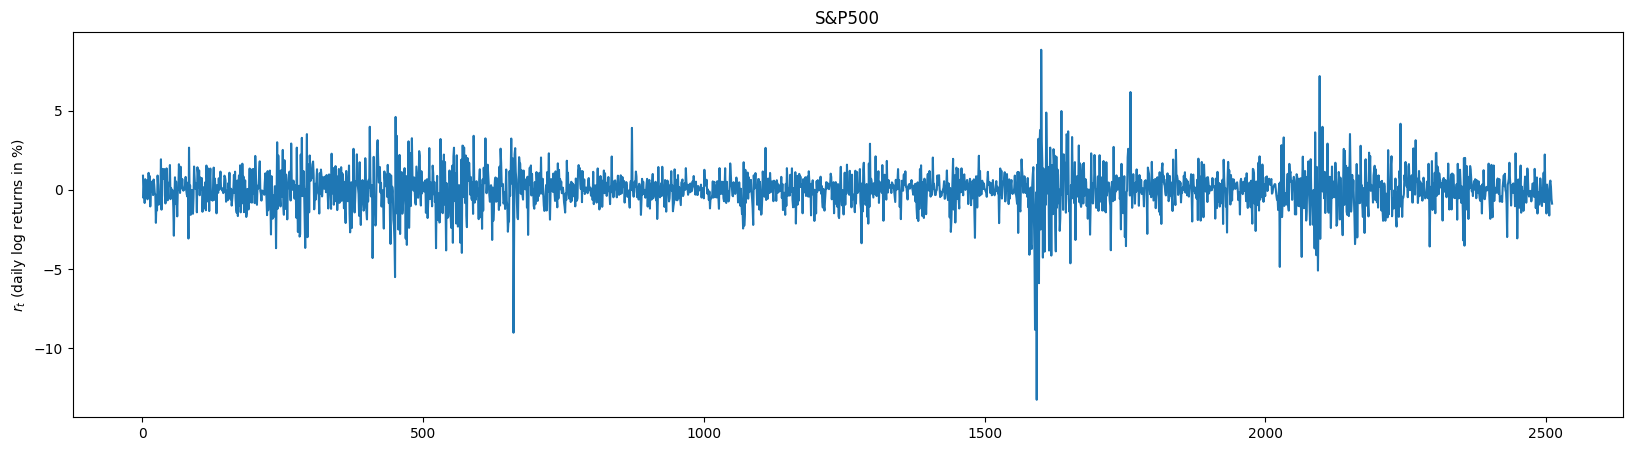

In [4]:
plt.figure(figsize=(20,5))
plt.plot(df['Adj Close'])
plt.ylabel(r"$S_t$ (adjusted closing price)")
plt.gcf().set_facecolor("white")
plt.title(r"S&P500")
plt.show()

plt.figure(figsize=(20,5))
plt.plot(df['logreturn'])
plt.ylabel(r"$r_t$ (daily log returns in %)")
plt.gcf().set_facecolor("white")
plt.title(r"S&P500")
plt.show()

In [5]:
fig = px.line(df, x= df.index, y=['Adj Close'])
fig.show()
fig = px.line(df, x= df.index, y=['logreturn'])
fig.show()

## (i) Compute the mean, standard deviation, skewness, and kurtosis of the log returns. Draw also a histogram including a kernel density estimate and a normal distribution (density) fitted to the log returns. What can you conclude?

In [6]:
mu = df['logreturn'].mean()
sigma = df['logreturn'].std()
print(f"mu_hat = {mu:.4%}")
print(f"sigma_hat = {sigma:.4%}")

mu_hat = 1.1063%
sigma_hat = 123.8184%


The mean log return is 1.1063%, and the standard deviation is 123.8184%. These values provide information about the central tendency and dispersion of the log returns.

In [7]:
skew = df['logreturn'].skew()
kurt = df['logreturn'].kurt()
print(f"Empirical Skewness = {skew:.4f} | Theoretical Skewness = 0")
print(f"Empirical Kurtosis = {kurt:.4f} | Theoretical Kurtosis = 3 (Excess Kurtosis = 0)")

Empirical Skewness = -0.7954 | Theoretical Skewness = 0
Empirical Kurtosis = 10.2873 | Theoretical Kurtosis = 3 (Excess Kurtosis = 0)


Skewness of SX5E return is -0.7954 while theoretical skewness of normal distribution is 0. Kurtosis of SX5E return is 10.2873 while theoretical kurtosis of normal distribution
is 3.

Skewness: a measurement of the distortion of symmetrical distribution or asymmetry in a data set

Kurtosis: a measurement of the "tailedness" of the distribution

The empirical skewness is -0.7954, indicating a slight leftward (negative) skewness. This means that the distribution of log returns is somewhat skewed to the left.

The empirical kurtosis is 10.2873, which is higher than the theoretical kurtosis for a normal distribution (3). This indicates heavy tails and more extreme values in the distribution compared to a normal distribution.

<Axes: xlabel='logreturn', ylabel='Proportion'>

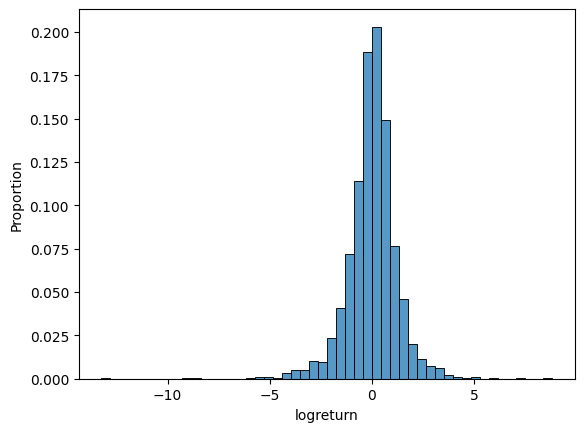

In [8]:
# The below shows the histogram of the daily return, as per slide 11, Part 1 of the lecture notes.
sns.histplot(data=df['logreturn'], bins=50, stat="proportion")

<Axes: xlabel='logreturn', ylabel='Density'>

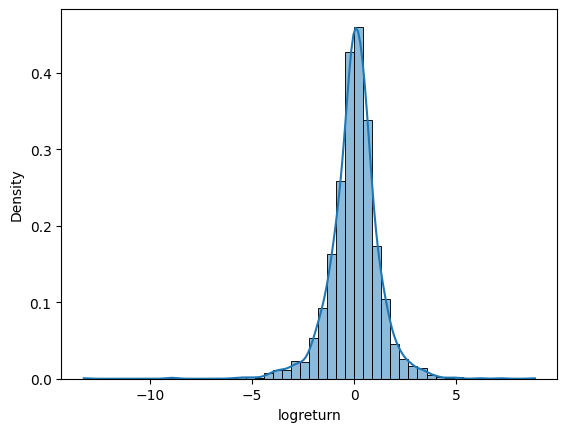

In [9]:
# Notice that the values are not the same as the previous plot because of the normalisation under stat="density".
sns.histplot(data=df['logreturn'], bins=50, stat="density", kde=True)

Next, we try to plot a $N(\mu,\sigma)$ pdf on top of the fitted kernel density estimator. The $\mu$ and $\sigma$ are estimated from the sample mean and standard deviation of the daily log returns.

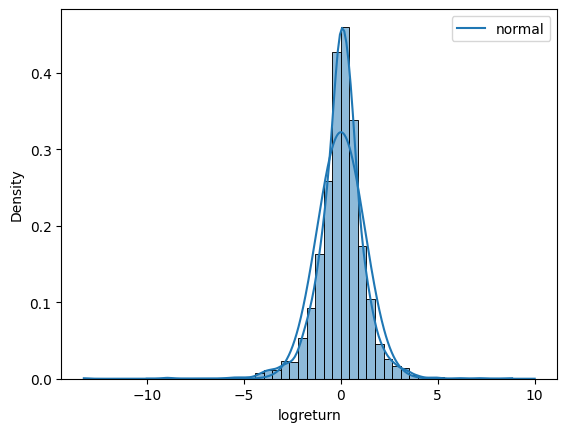

In [10]:
x = np.linspace(-10,10,1000)

# Add the plot of N(\mu,\sigma) pdf on top of the seaborn histogram
sns_ax = sns.histplot(data=df['logreturn'], bins=50, stat="density", kde=True)
sns_ax.plot(x,norm.pdf(x,mu,sigma),label="normal")
plt.legend()

The histogram and kernel density estimate provide a visual representation of the distribution of log returns. The fitted normal distribution density is overlaid on the histogram.

The fitted kernel estimator has a more acute peak and heavier tails relative to the normal pdf.

From the histograms of the returns in Figure 1, we can see that the empirical distribution of the S P500 arithmetic-returns are quite far from Gaussian distribution. In general it has fatter tails and is skewed compared to the histogram of simulated returns.

The negative skewness suggests that there may be more extreme negative returns than positive returns. The high kurtosis indicates fat tails in the distribution, implying a higher likelihood of extreme events. The visual examination of the histogram and kernel density estimate, along with the comparison to a normal distribution, can further support these statistical measures. It's important to note that the distribution of log returns might deviate from a normal distribution, and understanding these moments helps in characterizing the nature of the financial time series.

## (ii) Draw the empirical ACFs of the log returns, their absolute values, and their squares. What can you conclude?

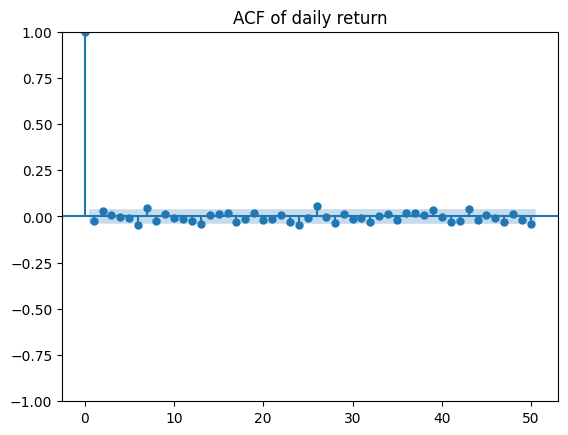

In [11]:
sm.graphics.tsa.plot_acf(df['logreturn'].dropna(), lags=50, title="ACF of daily return")
plt.show()

Observation: the empirical arithmetic-returns have serial correlation on this short time window, and the simulated returns behave more like a white noise.
Below is the ACF plot of the daily return $\rho(k)=Cor(r_t,r_{t-k})$ for $k=0,1,...,50$. The correlation values are very small (beyond $k=0$). This suggests forecasting daily returns based on historical values tends to be hard because of the lack of (linear) dependence.

The autocorrelation function (ACF) plot for the log returns suggests that there is little to no significant serial correlation in the returns beyond the lag of 0 (i.e., correlation values are very small beyond  (k=0). This implies that forecasting daily returns based on historical log returns might be challenging due to the lack of linear dependence.

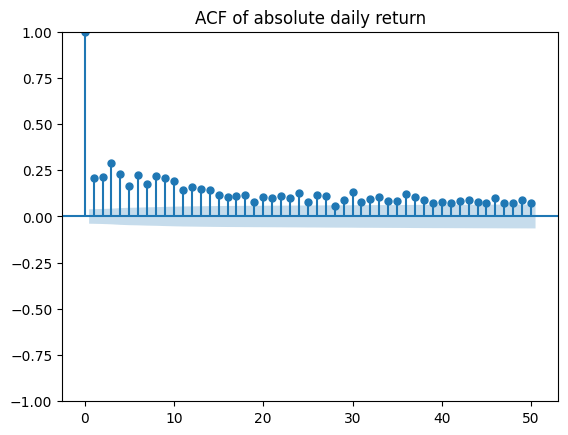

In [12]:
sm.graphics.tsa.plot_acf(np.abs(df['logreturn']).dropna(), lags=50, title="ACF of absolute daily return")
plt.show()

But if we plot the instead the ACF of the absolute daily return $\rho(k)=Cor(|r_t|,|r_{t-k}|)$, the values are now much more significant. This indicates the phenomenon of volatility clustering: a large move today tends to result in another large move in the near future (although we are not certain about the direction of move).

The effect is also very persistent over time where $\rho(k)$ remains significant for large value of $k$: the impact of a large move today can influence the move many days beyond.

Volatility Clustering:

When considering the ACF of the absolute daily returns (volatility), the correlation values are much more significant. This phenomenon is known as "volatility clustering," indicating that large price movements tend to be followed by more large movements in the near future. The persistence of significant correlation values for larger values of
k suggests that the impact of a large move today can influence the returns for many days into the future.

Persistence over Time:

The effect of volatility clustering is observed to be persistent over time, as indicated by the significant autocorrelation values for large k. This suggests that the impact of a large price move today can continue to influence the returns for an extended period.


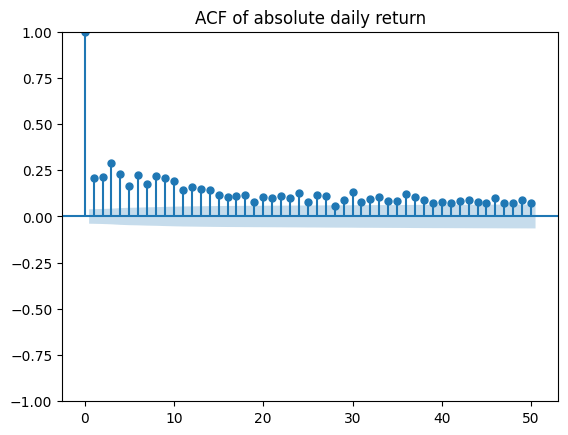

In [13]:
sm.graphics.tsa.plot_acf(np.abs(df['logreturn']).dropna(), lags=50, title="ACF of absolute daily return")
plt.show()

## (iii) Fit a standard GARCH(1,1) model, with constant conditional mean and standard normal innovations, to the log return data. Report the model fitting results. Plot the absolute returns and fitted volatilities. Comment on the results.

As an example, our time series $X=(X_t)_{t}$ will be the daily log-return.

Fitting a GARCH(1,1)-normal model

Recall that the specification of a GARCH(1,1) model is
\begin{align}
X_{t}=\sigma_t Z_t,\qquad \sigma_t^2=\alpha_0+\alpha_1 X_{t-1}^2 + \beta_1\sigma_{t-1}^2,
\end{align}
and in this case we assume $(Z_t)_t$ to be normally distributed strict white noises with common pdf $$f_Z(z)=\frac{1}{\sqrt{2\pi}}e^{-\frac{z^2}{2}}.$$

First, let's try to fit a GARCH(1,1) model by manually maximising the log-likelihood function in form of (Part 3, Slide 67) $$\ell(\alpha_0,\alpha_1,\beta_1;X)=\sum_{t=1}^T \left[-\log \sigma_t + \log f_Z\left(\frac{X_t}{\sigma_t}\right)\right]$$ with respect to $(\alpha_0,\alpha_1,\beta_1)$ the collection of GARCH parameters and $X=(X_t)_{t=0}^T$ is our observed data.

The block of code below implements the log-likelihood function under the specification of $Z\sim N(0,1)$ where the log-likelihood function is specialised to $$\ell(\alpha_0,\alpha_1,\beta_1;X)=\sum_{t=1}^T\left[-\frac{1}{2}\log \sigma_t^2-\frac{X_t^2}{2\sigma_t^2}-\frac{1}{2}\log (2\pi)\right]$$

Now we want to numerically solve the maximisation problem
\begin{align}
\sup_{\alpha_0,\alpha_1,\beta_1}\ell(\alpha_0,\alpha_1,\beta_1;X)
\end{align}
with constraints $\alpha_0\geq0$, $\alpha_1\geq 0$, $\beta_1\geq 0$ and the stationary condition $\alpha_1+\beta_1<1$.



In [14]:
# Create the model object:
# p,q refer to the order of GARCH(p,q) model
# "mean=zero" refers to no ARMA component
# "dist=normal"  refers to N(0,1) distribution of the white noise process Z
model = arch_model(df['logreturn'][1:], vol='Garch', mean='Constant', p=1, q=1, dist='normal') 

# Fit the model. Update_freq is a cosmetic parameter controlling how frequently the numerical iteration progress is reported on screen
res = model.fit(update_freq=5)

# Show the fitting results
print(res)

Iteration:      5,   Func. Count:     37,   Neg. LLF: 3795.3028168849614
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3747.842649781043
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3747.8426489828425
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              logreturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3747.84
Distribution:                  Normal   AIC:                           7503.69
Method:            Maximum Likelihood   BIC:                           7527.00
                                        No. Observations:                 2511
Date:                Thu, Nov 23 2023   Df Residuals:                     2510
Time:        

Mean Model: The constant mean (μ) is estimated to be 0.0476 with a t-statistic of 2.353, indicating statistical significance at a 5% level. This represents the average return in the model. 

Volatility Model: The GARCH(1,1) model includes ARCH and GARCH coefficients. The alpha (ARCH) coefficient is 0.1262, and the beta (GARCH) coefficient is 0.8251. Both coefficients are statistically significant.

Model Fit Evaluation:
The R-squared and adjusted R-squared values are both 0.000, suggesting that the model does not explain much of the variation in the data. This is not uncommon in financial time series modeling.
The log-likelihood is -3747.84, and the AIC and BIC values are provided for model comparison.


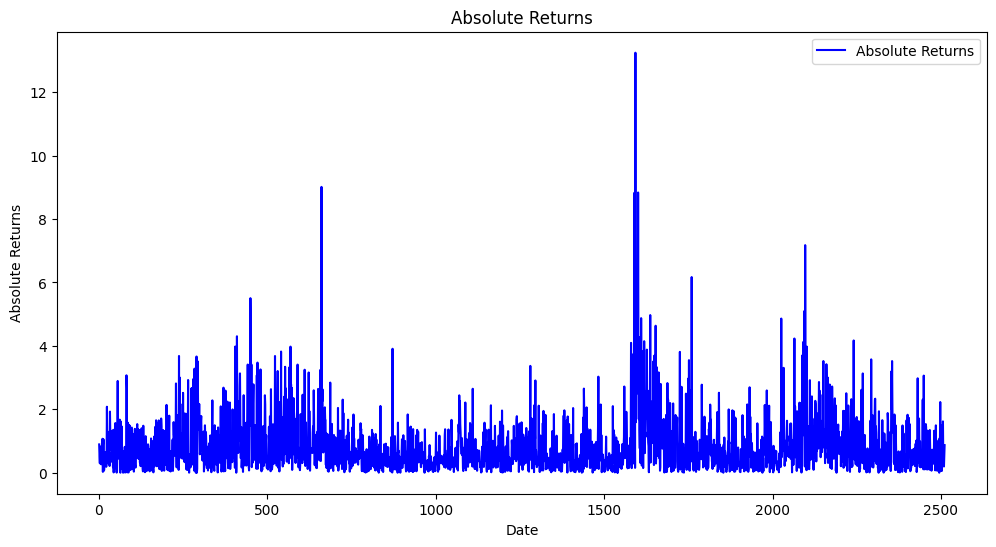

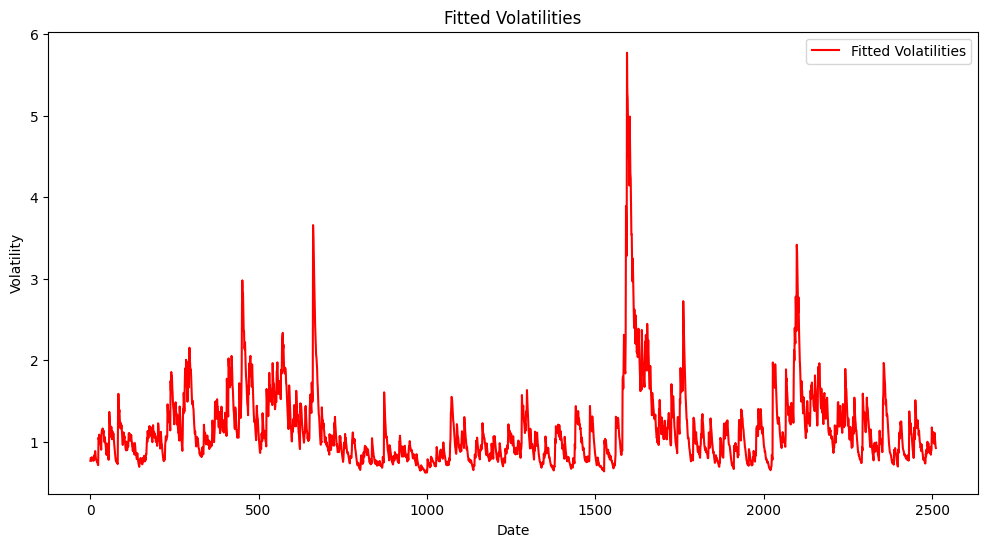

In [15]:
# Plot absolute returns
plt.figure(figsize=(12, 6))
plt.plot(df.index[1:], df['logreturn'][1:].abs(), label='Absolute Returns', color='blue')
plt.title('Absolute Returns')
plt.xlabel('Date')
plt.ylabel('Absolute Returns')
plt.legend()
plt.show()

# Plot fitted volatilities
plt.figure(figsize=(12, 6))
plt.plot(df.index[1:], res.conditional_volatility, label='Fitted Volatilities', color='red')
plt.title('Fitted Volatilities')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

Absolute Returns Plot (Blue Line): This plot shows the magnitude of the log returns over time. Peaks in the absolute returns may indicate periods of high volatility or large price movements.

Fitted Absolute Returns Plot (Red Line): This plot shows the absolute returns estimated by the GARCH(1,1) model over time. It represents the model's attempt to capture the changing volatility patterns in the data. Compare this plot with the absolute returns to see how well the model is capturing volatility spikes.

## (iv) Assess the goodness of fit of the model estimated in (iii). Do the standardised residuals look like an iid sample from the standard normal distribution?

To assess the goodness of fit of the GARCH(1,1) model estimated in part (iii), we can examine the standardized residuals and check if they resemble an independent and identically distributed (i.i.d.) sample from a standard normal distribution. Here's how you can do that:

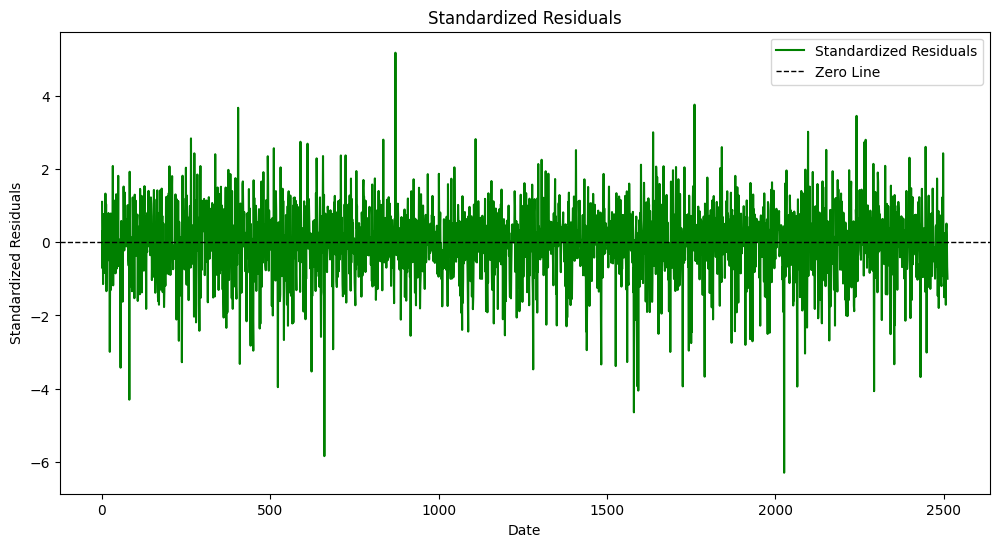

In [16]:
# Get the standardized residuals
std_resid = res.resid / res.conditional_volatility

# Plot the standardized residuals
plt.figure(figsize=(12, 6))
plt.plot(df.index[1:], std_resid, label='Standardized Residuals', color='green')
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Line')
plt.title('Standardized Residuals')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')
plt.legend()
plt.show()

In the plot:

The green line represents the standardized residuals.
The black dashed line represents the zero line, which the residuals should oscillate around if they are centered on zero.

Zero Mean: We can check if the mean of the standardized residuals is approximately zero. A deviation from zero might indicate a bias in the model.

Constant Variance: we can examine if the spread of the standardized residuals is relatively constant over time. Any systematic pattern in volatility could suggest a deficiency in the model.

Independence: We can look for patterns in the residuals over time. If there are autocorrelations or patterns, it may suggest that the model has not captured all the relevant information.


In [17]:
# Perform Shapiro-Wilk test on standardized residuals
statistic, p_value = shapiro(std_resid)

# Print the test statistic and p-value
print(f'Shapiro-Wilk Test Statistic: {statistic}')
print(f'P-value: {p_value}')

# Check the null hypothesis
alpha = 0.05
if p_value > alpha:
    print('The standardized residuals appear to be normally distributed (fail to reject the null hypothesis).')
else:
    print('The standardized residuals do not appear to be normally distributed (reject the null hypothesis).')

Shapiro-Wilk Test Statistic: 0.9713345766067505
P-value: 5.162719253098382e-22
The standardized residuals do not appear to be normally distributed (reject the null hypothesis).


To formally test whether the standardized residuals (std_resid) are independent and identically distributed (i.i.d.) from a standard normal distribution, you can use the Shapiro-Wilk test for normality. The Shapiro-Wilk test is a widely used test for normality.

The Shapiro-Wilk test for normality of the standardized residuals resulted in a very low p-value (5.162719253098382e-22), indicating a rejection of the null hypothesis. This suggests that the standardized residuals do not appear to be normally distributed.

Conclusion:

The GARCH(1,1) model has been successfully fitted to the log return data. The estimated coefficients for the mean, ARCH, and GARCH components are statistically significant. However, the model does not explain much of the variation in the data, as indicated by the low R-squared values. Additionally, the Shapiro-Wilk test suggests that the standardized residuals do not follow a normal distribution. Further diagnostics and model refinement may be needed to improve the model's fit and address the non-normality of residuals. Visualizing the absolute returns and fitted volatilities can provide additional insights into the model's performance.

Shapiro-Wilk Test for Normality:

Test Statistic: 0.9713345766067505
P-value: 5.162719253098382e-22
Standardized Residuals:

The standardized residuals do not appear to be normally distributed (reject the null hypothesis).
Interpretation:

The results of the Shapiro-Wilk test for normality and the observation that the standardized residuals do not appear to be normally distributed suggest that the model may not provide a good fit to the data. In an ideal scenario, the standardized residuals should resemble an independent and identically distributed (i.i.d.) sample from a standard normal distribution.

## (v) Fit an ARMA(1,1)–GARCH(1,1) model with Student t-distributed innovations. Does the new specification improve the fit, compared to the model in (iii)? Is the ARMA(1,1) part necessary?


To fit an ARMA(1,1)–GARCH(1,1) model with Student t-distributed innovations in Python using the arch library, you can use the following code:

In [19]:
meanMdl = ag.ARMA(order = {'AR':1, 'MA':1})
volMdl = ag.garch(order = {'p':1, 'q':1})
dist = ag.tStudent()

mdl = ag.empModel(pd.DataFrame(df['logreturn'].dropna()), meanMdl, volMdl, dist)
mdl.fit()

c:\Users\thoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\armagarch\tStudent.py:44: RuntimeWarning:

invalid value encountered in divide



                         ARMA-GARCH estimation results                          
Dep Variable:               logreturn    R-squared:                       -0.0
Mean Model:                      ARMA    Adj. R-squared:                 -0.01
Vol Model:                      GARCH    Log Likelihood:              -3644.24
Distribution:                 Student    AIC:                          7302.48
Method:                            ML    BIC:                          7343.28
                                         Num obs:                         2511
Date:                Thu, Nov 23 2023    Df Residuals:                    2505
Time:                        14:48:19    Df Model:                           6
                                                                                
                                   Mean Model                                   
                            Estimate          Std. Error              t-stat
------------------------------------------------

In [41]:
from scipy import stats

# Get the standardized residuals for the ARMA(1,1)–GARCH(1,1) model
std_resid_arma_garch = mdl.stres
std_resid_arma_garch=np.asarray(std_resid_arma_garch, dtype=float)
std_resid_arma_garch = std_resid_arma_garch.flatten()
df, loc, scale = stats.t.fit(std_resid_arma_garch)

# Perform a goodness-of-fit test (e.g., Kolmogorov-Smirnov test)
ks_statistic, ks_p_value = stats.kstest(std_resid_arma_garch, 't', args=(df, loc, scale))
print(f"Kolmogorov-Smirnov Test Statistic: {ks_statistic}")
print(f"P-value: {ks_p_value}")

Kolmogorov-Smirnov Test Statistic: 0.022541483753394737
P-value: 0.15348279576183954


# Part B : Risk Measures

You can find below the commented code corresponding to the graphs and tables computed in Part b of the assessed work.

In [ ]:
### -------------------------------- Historical Simulation (HS) ---------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2


# Load the data file
file_path = 'C:/Users/paulw/OneDrive/Bureau/Documents-Perso/Scolarité/Imperial/QRM-2023-cw1-data-b.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the data to understand its structure
#print(data.head())


# Convert Date to datetime for easier manipulation
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# Sort data by date in case it's not sorted
data.sort_values(by='Date', inplace=True)

# Calculate daily log returns
data['Log Return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

# Display the first few rows with log returns
#print(data.head())

# # Define a function to calculate VaR and ES using Historical Simulation
def historical_simulation(log_returns, window_size, confidence_levels):
    """
    Calculate VaR and ES using historical simulation.

    :param log_returns: Series of log returns
    :param window_size: Size of the rolling window
    :param confidence_levels: List of confidence levels for VaR calculation
    :return: DataFrames containing VaR and ES forecasts for each confidence level
    """
    # Initialize dictionaries to store VaR and ES values
    var_forecasts = {conf: [] for conf in confidence_levels}
    es_forecasts = {conf: [] for conf in confidence_levels}

    # Iterate over the log returns
    for i in range(window_size, len(log_returns)):
        # Get the window of returns
        window = log_returns[i-window_size:i]

        # Calculate VaR and ES for each confidence level
        for conf in confidence_levels:
            # Calculate VaR (percentile)
            var_forecasts[conf].append(window.quantile(1 - conf))

            # Calculate ES (average of worse returns than VaR)
            es_forecasts[conf].append(window[window <= var_forecasts[conf][-1]].mean())

    # Convert the results to DataFrames
    var_forecasts_df = pd.DataFrame(var_forecasts, index=log_returns.index[window_size:])
    es_forecasts_df = pd.DataFrame(es_forecasts, index=log_returns.index[window_size:])

    return var_forecasts_df, es_forecasts_df

# Parameters
window_size = 500
confidence_levels = [0.95, 0.99]

# Calculate VaR and ES forecasts using Historical Simulation
var_forecasts_hs, es_forecasts_hs = historical_simulation(data['Log Return'].dropna(), window_size, confidence_levels)

# Display the first few rows of the results
var_forecasts_hs.head(), es_forecasts_hs.head()


### --- Plot ----

# Ensure dates are in datetime format and sorted
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

start_date_index = window_size + 1  # Adjust this if needed

# # Plotting
# plt.figure(figsize=(14, 7))

# # Actual positive losses
# plt.fill_between(data['Date'][start_date_index:], 0, data['Log Return'][start_date_index:].clip(lower=0), color='orange', alpha=0.5)

# # HS VaR and ES for 95% confidence level
# plt.plot(data['Date'][start_date_index:], -var_forecasts_hs[0.95], label='95% VaR', linestyle='--', color='blue')
# plt.plot(data['Date'][start_date_index:], -es_forecasts_hs[0.95], label='95% ES', color='red')

# # HS VaR and ES for 99% confidence level
# plt.plot(data['Date'][start_date_index:], -var_forecasts_hs[0.99], label='99% VaR', linestyle='--', color='blue', alpha=0.5)
# plt.plot(data['Date'][start_date_index:], -es_forecasts_hs[0.99], label='99% ES', color='red', alpha=0.5)

# # Customize the plot
# plt.xlabel('Time')
# plt.ylabel('Positive part of daily portfolio loss (%)')
# plt.title('Historical simulation, time window: 500 business days')
# plt.legend(loc='upper left')
# plt.grid(True)
# plt.tight_layout()  # Adjust the padding between and around subplots
# plt.show()


### -------------------------------------- EWMA volatility forecast ------------------------------------

window_size = 500
# Initial value based on the variance of the first few returns
initial_variance = data['Log Return'].dropna()[:window_size].var()

# Define the EWMA volatility forecast function
def ewma_volatility(log_returns, alpha):
    lambda_ = 1 - alpha
    ewma_variance = log_returns.copy()
    ewma_variance.iloc[0] = initial_variance  # Initial value

    # Calculate the EWMA variance
    for i in range(1, len(log_returns)):
        ewma_variance.iloc[i] = lambda_ * ewma_variance.iloc[i - 1] + (1 - lambda_) * log_returns.iloc[i - 1]**2

    # Convert variance to volatility
    ewma_volatility = np.sqrt(ewma_variance)
    return ewma_volatility

# Define a function to calculate standardized residuals
def standardized_residuals(log_returns, volatility):
    return -log_returns / volatility

# EWMA parameters
alpha = 0.06

# Calculate EWMA volatility forecasts
ewma_vol = ewma_volatility(data['Log Return'].dropna(), alpha)

# Calculate standardized residuals
std_residuals = standardized_residuals(data['Log Return'].dropna(), ewma_vol)

# Calculate VaR using EWMA
def calculate_ewma_var(ewma_vol, confidence_levels):
    var_forecasts = {}
    for conf in confidence_levels:
        z_score = norm.ppf(1 - conf)
        var_forecasts[conf] = ewma_vol * z_score

    return pd.DataFrame(var_forecasts, index=ewma_vol.index)

# Calculate VaR forecasts using EWMA volatilities
var_forecasts_fhs_ewma = calculate_ewma_var(ewma_vol, confidence_levels)

# Calculate FHS VaR and ES using standardized residuals
def calculate_fhs_es(std_residuals, ewma_vol, window_size, confidence_levels):
    es_forecasts = {}
    for conf in confidence_levels:
        var_level = std_residuals.rolling(window_size).quantile(1 - conf)
        es = std_residuals[std_residuals <= var_level].mean()
        es_forecasts[conf] = es * ewma_vol  # Adjust ES for current volatility

    return pd.DataFrame(es_forecasts, index=ewma_vol.index)

# Calculate FHS ES forecasts
es_forecasts_fhs_ewma = calculate_fhs_es(std_residuals, ewma_vol, window_size, confidence_levels)

# Display the first few rows of the FHS EWMA results
var_forecasts_fhs_ewma.head(), es_forecasts_fhs_ewma.head()


### --- Plot ----

# Ensure dates are in datetime format and sorted
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

start_date_index = window_size + 1  # Adjust this if needed

# # Plotting
# plt.figure(figsize=(14, 7))

# # Actual positive losses
# plt.fill_between(data['Date'][start_date_index:], 0, data['Log Return'][start_date_index:].clip(lower=0), color='orange', alpha=0.5)

# # HS VaR and ES for 95% confidence level
# plt.plot(data['Date'][start_date_index:], -var_forecasts_fhs_ewma[0.95][500:], label='95% VaR', linestyle='--', color='blue')
# plt.plot(data['Date'][start_date_index:], -es_forecasts_fhs_ewma[0.95][500:], label='95% ES', color='red')

# # HS VaR and ES for 99% confidence level
# plt.plot(data['Date'][start_date_index:], -var_forecasts_fhs_ewma[0.99][500:], label='99% VaR', linestyle='--', color='blue', alpha=0.5)
# plt.plot(data['Date'][start_date_index:], -es_forecasts_fhs_ewma[0.99][500:], label='99% ES', color='red', alpha=0.5)

# # Customize the plot
# plt.xlabel('Time')
# plt.ylabel('Positive part of daily portfolio loss (%)')
# plt.title('Filtered Historical simulation (EWMA), time window: 500 business days')
# plt.legend(loc='upper left')
# plt.grid(True)
# plt.tight_layout()  # Adjust the padding between and around subplots
# plt.show()


###-------------------------------- GARCH MODEL -----------------------------

from arch import arch_model

# Define a function to estimate GARCH(1,1) model and calculate standardized residuals
def garch_conditional_volatility_(log_returns):
    """
    Estimate GARCH(1,1) model and calculate standardized residuals.

    :param log_returns: Series of log returns
    :return: Series of standardized residuals from the GARCH model
    """
    # Fit the GARCH(1,1) model
    garch11 = arch_model(log_returns, vol='Garch', p=1, q=1, mean='zero')
    model_result = garch11.fit(update_freq=10, disp='off')

    # Get the conditional volatility
    conditional_volatility = model_result.conditional_volatility

    # Calculate standardized residuals

    return conditional_volatility

def garch_standardized_residuals(log_returns, conditional_volatility):
    return log_returns / conditional_volatility

# Calculate standardized residuals from the GARCH(1,1) model
garch_conditional_volatility = garch_conditional_volatility_(data['Log Return'].dropna())
garch_std_residuals = garch_standardized_residuals(data['Log Return'].dropna(), garch_conditional_volatility)

# Define the window size and confidence levels for VaR and ES calculation
window_size = 500
confidence_levels = [0.95, 0.99]

# Function to calculate VaR and ES using GARCH(1,1)
def calculate_garch_var_es(conditional_volatility, confidence_levels):
    var_forecasts = {}
    es_forecasts = {}

    for conf in confidence_levels:
        z_score = norm.ppf(conf)
        var_forecasts[conf] = conditional_volatility * z_score

        # For a normal distribution, ES can be calculated using VaR and the standard normal density
        es_forecasts[conf] = conditional_volatility * z_score * norm.pdf(z_score) / (1 - conf)

    return pd.DataFrame(var_forecasts, index=conditional_volatility.index), pd.DataFrame(es_forecasts, index=conditional_volatility.index)

# Calculate GARCH-based VaR and ES forecasts
var_forecasts_fhs_garch, es_forecasts_fhs_garch = calculate_garch_var_es(garch_conditional_volatility, confidence_levels)

# Display the first few rows of the FHS GARCH results
print(var_forecasts_fhs_garch.head())
print(es_forecasts_fhs_garch.head())

### Plotting Section: Add the GARCH-based VaR and ES plots

# Display the first few rows of the FHS GARCH results
print(var_forecasts_fhs_garch.head())
print(es_forecasts_fhs_garch.head())

### --- Plot ----

# Ensure dates are in datetime format and sorted
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

start_date_index = window_size + 1  # Adjust this if needed

# # Plotting
# plt.figure(figsize=(14, 7))

# # Actual positive losses
# plt.fill_between(data['Date'][start_date_index:], 0, data['Log Return'][start_date_index:].clip(lower=0), color='orange', alpha=0.5)

# # HS VaR and ES for 95% confidence level
# plt.plot(data['Date'][start_date_index:], var_forecasts_fhs_garch[0.95][500:], label='95% VaR', linestyle='--', color='blue')
# plt.plot(data['Date'][start_date_index:], es_forecasts_fhs_garch[0.95][500:], label='95% ES', color='red')

# # HS VaR and ES for 99% confidence level
# plt.plot(data['Date'][start_date_index:], var_forecasts_fhs_garch[0.99][500:], label='99% VaR', linestyle='--', color='blue', alpha=0.5)
# plt.plot(data['Date'][start_date_index:], es_forecasts_fhs_garch[0.99][500:], label='99% ES', color='red', alpha=0.5)

# # Customize the plot
# plt.xlabel('Time')
# plt.ylabel('Positive part of daily portfolio loss (%)')
# plt.title('Filtered historical simulation (GARCH), time window: 500 business days')
# plt.legend(loc='upper left')
# plt.grid(True)
# plt.tight_layout()  # Adjust the padding between and around subplots
# plt.show()


###------------ Backtesting --------------------------


var95_hs_violations = (-data['Log Return'][start_date_index:] > abs(var_forecasts_hs[0.95])).astype(int)
var95_ewma_violations = (-data['Log Return'][start_date_index:] > abs(var_forecasts_fhs_ewma[0.95][500:])).astype(int)
var95_garch_violations = (-data['Log Return'][start_date_index:] > abs(var_forecasts_fhs_garch[0.95][500:])).astype(int)

var99_hs_violations = (-data['Log Return'][start_date_index:] > abs(var_forecasts_hs[0.99])).astype(int)
var99_ewma_violations = (-data['Log Return'][start_date_index:] > abs(var_forecasts_fhs_ewma[0.99][500:])).astype(int)
var99_garch_violations = (-data['Log Return'][start_date_index:] > abs(var_forecasts_fhs_garch[0.99][500:])).astype(int)


# Define the Unconditional Coverage Test function
def unconditional_coverage_test(violations, alpha):
    total_observations = len(violations)
    number_of_violations = violations.sum()
    expected_violations = total_observations * (1 - alpha)

    test_statistic = -2 * (expected_violations * np.log(1 - alpha) + (total_observations - expected_violations) * np.log(alpha))
    if number_of_violations > 0:
        test_statistic += 2 * (number_of_violations * np.log(number_of_violations / total_observations) +
                               (total_observations - number_of_violations) * np.log(1 - number_of_violations / total_observations))

    p_value = 1 - chi2.cdf(test_statistic, df=1)
    return test_statistic, p_value, number_of_violations

# Confidence level used for VaR forecasts
alpha_95 = 0.95
alpha_99 = 0.99

# Calculate the test statistic and p-value for each VaR method
results = {}
results['VaR 95% HS'] = unconditional_coverage_test(var95_hs_violations, alpha_95)
results['VaR 95% EWMA'] = unconditional_coverage_test(var95_ewma_violations, alpha_95)
results['VaR 95% GARCH'] = unconditional_coverage_test(var95_garch_violations, alpha_95)

results['VaR 99% HS'] = unconditional_coverage_test(var99_hs_violations, alpha_99)
results['VaR 99% EWMA'] = unconditional_coverage_test(var99_ewma_violations, alpha_99)
results['VaR 99% GARCH'] = unconditional_coverage_test(var99_garch_violations, alpha_99)

# Create a DataFrame to display the results
results_df = pd.DataFrame(results, index=['LRuc', 'P-value', 'Violations']).T

# Display the results table
print(results_df)


# Define the function for the Independence Test
def independence_test(var_violations):
    # Calculate lagged indicator variables for independence test
    lagged_indicator = var_violations.shift(1)  # Lag by one day

    # Create a contingency table for the Chi-Square Test of Independence
    contingency_table = pd.crosstab(lagged_indicator, var_violations)

    # Calculate the Chi-Square statistic manually
    observed = contingency_table.to_numpy()
    chi2_stat = np.sum((observed - np.outer(contingency_table.sum(axis=1), contingency_table.sum(axis=0)) / observed.sum())**2 / (np.outer(contingency_table.sum(axis=1), contingency_table.sum(axis=0)) / observed.sum()))

    # Calculate degrees of freedom
    df = (contingency_table.shape[0] - 1) * (contingency_table.shape[1] - 1)

    # Calculate the p-value
    p_value = 1 - chi2.cdf(chi2_stat, df)

    return chi2_stat, p_value

# Confidence levels for VaR forecasts
confidence_levels = [0.95, 0.99]

# Results dictionary to store test statistics and p-values for each method
results_independence = {}

# List of methods
methods = ['HS', 'FHS EWMA', 'FHS GARCH']

# Iterate through each method
for method in methods:
    results_independence[method] = {}
    
    # Perform Independence Test for each confidence level
    for alpha in confidence_levels:
        results_independence[method][f'Independence Test {int(alpha * 100)}%'] = []

        # Define the VaR violations for the selected confidence level and method
        if method == 'HS':
            var_violations = (-data['Log Return'][start_date_index:] > abs(var_forecasts_hs[alpha])).astype(int)
        elif method == 'FHS EWMA':
            var_violations = (-data['Log Return'][start_date_index:] > abs(var_forecasts_fhs_ewma[alpha][500:])).astype(int)
        elif method == 'FHS GARCH':
            var_violations = (-data['Log Return'][start_date_index:] > abs(var_forecasts_fhs_garch[alpha][500:])).astype(int)

        # Perform the Independence Test and store results
        chi2_stat, p_value = independence_test(var_violations)
        results_independence[method][f'Independence Test {int(alpha * 100)}%'].extend([chi2_stat, p_value])

# Create DataFrames to mimic the desired output format
independence_results_dfs = {}
for method in methods:
    independence_results_dfs[method] = pd.DataFrame(results_independence[method], index=['Chi-Square Statistic', 'P-value'])

# Print the results in the desired format
for method, df in independence_results_dfs.items():
    print(f'{method}\n{df}\n')


import pandas as pd
import numpy as np
from scipy.stats import chi2

# Define the function for the Independence Test (similar to previous code)
def independence_test(var_violations):
    # Calculate lagged indicator variables for independence test
    lagged_indicator = var_violations.shift(1)  # Lag by one day

    # Create a contingency table for the Chi-Square Test of Independence
    contingency_table = pd.crosstab(lagged_indicator, var_violations)

    # Calculate the Chi-Square statistic manually
    observed = contingency_table.to_numpy()
    chi2_stat = np.sum((observed - np.outer(contingency_table.sum(axis=1), contingency_table.sum(axis=0)) / observed.sum())**2 / (np.outer(contingency_table.sum(axis=1), contingency_table.sum(axis=0)) / observed.sum()))

    # Calculate degrees of freedom
    df = (contingency_table.shape[0] - 1) * (contingency_table.shape[1] - 1)

    # Calculate the p-value
    p_value = 1 - chi2.cdf(chi2_stat, df)

    return chi2_stat, p_value

# Define the function for the Joint Test for Coverage and Independence
def joint_test_coverage_independence(var_violations, alpha):
    # Perform Unconditional Coverage Test
    total_observations = len(var_violations)
    number_of_violations = var_violations.sum()
    expected_violations = total_observations * (1 - alpha)

    uc_test_statistic = -2 * (expected_violations * np.log(1 - alpha) + (total_observations - expected_violations) * np.log(alpha))
    if number_of_violations > 0:
        uc_test_statistic += 2 * (number_of_violations * np.log(number_of_violations / total_observations) +
                                   (total_observations - number_of_violations) * np.log(1 - number_of_violations / total_observations))

    uc_p_value = 1 - chi2.cdf(uc_test_statistic, df=1)

    # Perform Independence Test
    chi2_stat, ind_p_value = independence_test(var_violations)

    # Calculate the Joint Test statistic as the sum of UC and Independence Test statistics
    joint_test_statistic = uc_test_statistic + chi2_stat

    # Calculate the Joint Test p-value as the maximum of UC and Independence Test p-values
    joint_p_value = max(uc_p_value, ind_p_value)

    return joint_test_statistic, joint_p_value

# Confidence levels for VaR forecasts
confidence_levels = [0.95, 0.99]

# Results dictionary to store test statistics and p-values for each method
results_joint_test = {}

# List of methods
methods = ['HS', 'FHS EWMA', 'FHS GARCH']

# Iterate through each method and confidence level
for method in methods:
    results_joint_test[method] = {}
    
    for alpha in confidence_levels:
        results_joint_test[method][f'Joint Test {int(alpha * 100)}%'] = []

        # Define the VaR violations for the selected confidence level and method
        if method == 'HS':
            var_violations = (-data['Log Return'][start_date_index:] > abs(var_forecasts_hs[alpha])).astype(int)
        elif method == 'FHS EWMA':
            var_violations = (-data['Log Return'][start_date_index:] > abs(var_forecasts_fhs_ewma[alpha][500:])).astype(int)
        elif method == 'FHS GARCH':
            var_violations = (-data['Log Return'][start_date_index:] > abs(var_forecasts_fhs_garch[alpha][500:])).astype(int)

        # Perform the Joint Test for Coverage and Independence and store results
        joint_test_statistic, joint_p_value = joint_test_coverage_independence(var_violations, alpha)
        results_joint_test[method][f'Joint Test {int(alpha * 100)}%'].extend([joint_test_statistic, joint_p_value])

# Create DataFrames to mimic the desired output format
joint_test_results_dfs = {}
for method in methods:
    joint_test_results_dfs[method] = pd.DataFrame(results_joint_test[method], index=['Joint Test Statistic', 'P-value'])

# Print the results 
for method, df in joint_test_results_dfs.items():
    print(f'{method}\n{df}\n')
